# text-mining exploration of Hakluyt

##### imports, setup, HK functions code #####

In [1]:
# various imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from collections import Counter

#plot size setup
plt.rcParams["figure.figsize"] = (12,5)

# pandas settings to use its dataframe for printing tables
pd.set_option("display.max_rows", None, "display.max_columns", None, 'display.width', 1000)

# basic metadata retrieval functions against the Hakluyt txt files
# cf. Hakluyt_pdfminer extract from CambridgeCore pdfs.ipynb, 
# FineReader texts processing .ipynb
# & Hakluyt txt ledger.ipynb
test_filename = '01_44_NNE-_1313_The_letters_of_Edward_the_second_unto_Haquinus_King_of_Norway_concerning_certain_English_Merchants_a_pp.339-343.txt'

def HK_date(fileid):
    #extracts date component from Hakluyt text file name, returns as integer
    return(int(fileid[11:15]))
def HK_geog(fileid):
    #extracts geography component from Hakluyt text file name, returns as string
    return(fileid[6:10])
def HK_title(fileid):
    #extracts geography component from Hakluyt text file name, returns as string
    return(fileid[16:-15])
def HK_vol(fileid):
    #extracts volume component from Hakluyt text file name, returns as integer
    return(int(fileid[:2]))
def HK_chap(fileid):
    #extracts chapter component from Hakluyt text file name, returns as integer
    return(int(fileid[3:5]))
def HK_pages(fileid):
    #extracts page range component from Hakluyt text file name, returns as tuple of integers
    pages_char = fileid[-11:-4]
    pages_char_split = pages_char.split('-')
    return(int(pages_char_split[0]), int(pages_char_split[1]))
def HK_page_length(fileid):
    #extracts page length component from Hakluyt text file name, returns as integer
    first_page, last_page = HK_pages(fileid)
    return(last_page-first_page+1)

In [2]:
#returning tags based on ledger file
import os
import csv
def HK_tags(fileid):
    with open('text-data/ledgertagged.csv') as ledgertaggedcsv:
        ledger = csv.DictReader(ledgertaggedcsv, delimiter = ",")
        tags = []
        for row in ledger:
            if int(row['vol'])==HK_vol(fileid) and int(row['chap'])==HK_chap(fileid):
                tags.append(row['tag1'])
                if row['tag2']:
                    tags += row['tag2'].split(", ")
    return(tags)

In [3]:
# s, e = HK_pages(test_filename)
print(HK_tags(test_filename))

['doc', 'letter', 'england', 'norway']


##### chapter length spread code #####

In [4]:
# setting up basic text corpuses

import nltk
from nltk.corpus import PlaintextCorpusReader
# unfiltered corpuses
corpus_root = 'text-data/Cambridge_MacLehose_FineReader_OCR_trimmed'
hakluyt = PlaintextCorpusReader(corpus_root, '.*')
from nltk.text import TextCollection
hakluyt_col = TextCollection(hakluyt)

In [5]:
# setting up text corpuses based on MorphAdorn's lemmatization

corpus_lem_path = 'text-data/CC_ML_FR_trimmed_morphad_lem'
hakluyt_lem = PlaintextCorpusReader(corpus_lem_path, '.*')

In [6]:
# setting up categorized corpus based on both the nar/doc and the extended tags
# reminder that nar vs doc is a neat exclusive division of the corpus into two bins, 
# while the other tags both overlap and skip
filelist = os.listdir(corpus_lem_path)
fileid_tags = {}
with open('text-data/ledgertagged.csv') as ledgertaggedcsv:
    ledger = csv.DictReader(ledgertaggedcsv, delimiter = ",")
    for file in filelist:
        fileid_tags[file] = HK_tags(file)
from nltk.corpus import CategorizedPlaintextCorpusReader
hakluyt_lem_cat_tags = CategorizedPlaintextCorpusReader(corpus_lem_path, '.*', cat_map = fileid_tags)

In [7]:
# setting up categorized corpus based on geography
# should in principle work by extracting category from filename but doesn't

# import re
# hakluyt_cat_geog = CategorizedPlaintextCorpusReader(corpus_root, '.*', cat_pattern = r'(NNE-|SSE1|SSE2|AMER)')
# hakluyt_cat_geog.categories()
# re.findall(r'NNE-|SSE1|SSE2|AMER', r'01_16_NNE-_1246_Libellus_historicus_Johannis_de_Plano_Carpini_pp.055-094')

In [8]:
# setting up categorized corpus based on geography
#working, if less efficient solution - mirroring the above tags routine

filelist = os.listdir(corpus_lem_path)
fileid_geog = {}
for file in filelist:
    fileid_geog[file] = [HK_geog(file)]
from nltk.corpus import CategorizedPlaintextCorpusReader
hakluyt_lem_cat_geog = CategorizedPlaintextCorpusReader(corpus_lem_path, '.*', cat_map = fileid_geog)

In [9]:
# chapter / word counts for every geog region as a separate category and then for all of them together
geogs = ['NNE-', 'SSE1', 'SSE2', 'AMER']
chapters = [len(hakluyt_lem_cat_geog.fileids(categories = geog)) for geog in geogs + [geogs]]
words = [len(hakluyt_lem_cat_geog.words(categories = geog)) for geog in geogs + [geogs]]
chapters_words_df = pd.DataFrame(columns = [geogs + ['total']], index = ['chapters', 'words', 'avg chap len'])
chapters_words_df.loc['chapters'] = chapters
chapters_words_df.loc['words'] = words
chapters_words_df.loc['avg chap len'] = [int(words[i]/chapters[i]) for i in range(5)]

In [10]:
# chapter date frequency through single region
# cfd = nltk.FreqDist(HK_date(fileid) for fileid in hakluyt_cat_geog.fileids(categories = 'NNE-'))
# x = list(range(270,1600))
# y = [cfd[date] for date in x]
# plt.plot(x,y)
# x2=list(range(270,1600,10))

In [11]:
#histogram with transparency overlay
# for geog in geogs:
#     plt.hist([HK_date(fileid) for fileid in hakluyt_cat_geog.fileids(categories = geog)], bins = 15, alpha=0.5, label = geog)
# plt.legend()
# plt.title('histogram of chapter date frequencies')
# plt.show()

## Basic numberic overview

Hakluyt's second edition of **The Principal Navigations, Voyages, Traffiques and Discoveries of the English Nation**, 1598-1600, was printed in three volumes (expanding on the single-volume 1589 edition); the second volume broken down into two sub-sections as follows:

**NNE-**: "the North and Northeast quarters of the World"

**SSE1**: "the South and South-east quarters of the world, within the Straight of Gibraltar"

**SSE2**: essentially Africa outside of the Mediterranean, followed by southern Asia: "the South and Southeast quarters of the world without the Straights of Gibraltar, namely to the Hands of Madera, and of the Canaries, to the kingdome of Barbarie, to the Iles of Capo Verde, to the River of Senga, to the Coast of Ghinea and Benin, about the Cape of Buona Esperanza, and so to Goa in the East Indies, and likewise beyond cape Comori to the Iles of Nicubar, to Sumatra, to the Channell of Sincapura over against the City of Malacca, and to divers other places"

**AMER**: "the Northwest, West, and Southwest parts of the world"

### chapter and word numbers by geographic region

                NNE-    SSE1    SSE2    AMER    total
chapters         188     144      59     198      589
words         607689  321623  220912  923198  2073422
avg chap len    3232    2233    3744    4662     3520


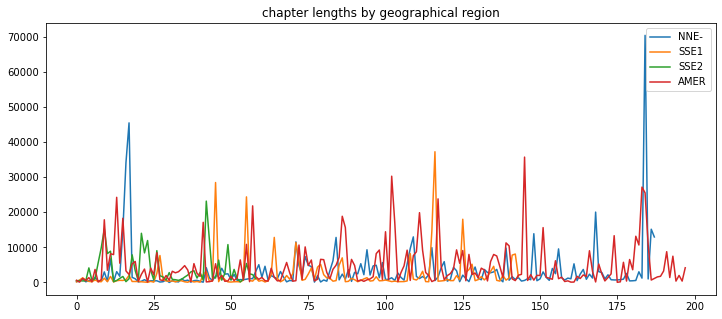

In [12]:
# chapter / word counts for every geog region as a separate category and then for all of them together
print(chapters_words_df)
# simple plotting of chapter lengths to get a sense of the variability
for geog in geogs:
    plt.plot([len(hakluyt_lem_cat_geog.words(fileid)) for fileid in hakluyt_lem_cat_geog.fileids(categories = geog)], label = geog)
plt.legend()
plt.title('chapter lengths by geographical region')
plt.show()

Interestingly, the American volume is not only the longest one in both chapter number and word length, but also has the longest chapters on average; it accounts for nearly half the collection, despite the fact that the English have barely started engaging with the new continent, and Europeans overall have just about one century of well-documented American encounters, as opposed to thousands of years for Europe, Asia and Africa. Hakluyt is clearly singling it out for special treatment. Africa outside the Mediterranean and South Asia, on the other hand, get a definite short shrift. There's a good deal of chapter length variability in each region, but NNE takes the lead with two outliers longer than any other chapter in any region.

### chapter date distributions by geographic region

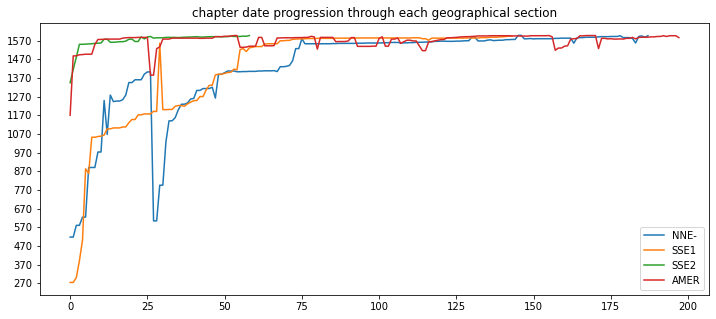

In [13]:
for geog in geogs:
    plt.plot([HK_date(fileid) for fileid in hakluyt_lem_cat_geog.fileids(categories = geog)], label = geog)
plt.legend()
plt.yticks(range(270, 1600, 100))
plt.title('chapter date progression through each geographical section')
plt.show()

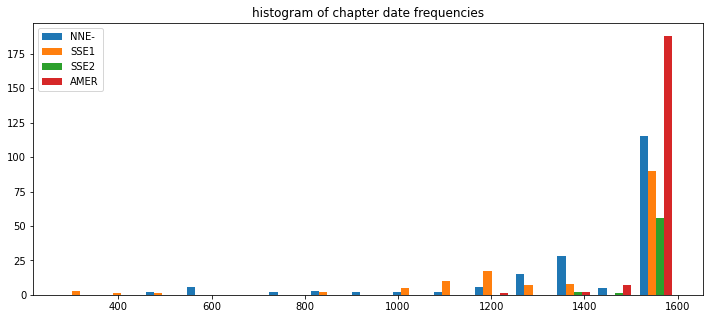

In [14]:
store={}
for geog in geogs:
    store[geog] = [HK_date(fileid) for fileid in hakluyt_lem_cat_geog.fileids(categories = geog)]
plt.hist([store[geog] for geog in geogs], bins=15, label = geogs)
plt.legend()
plt.title('histogram of chapter date frequencies')
plt.show()

Clearly, the compilation is heavily skewed in favor of the most recent few decades. While this is true across the board, however, there are differences in detail. Both the very short section on extra-Mediterranean Africa & South Asia and the extended American section only briefly touch on past centuries before jumping up to more recent times--very understandably in the latter case, as Europe had scant recorded pre-16th c. encounters with America. North Europe & Russia, as well as the Mediterranean region, on the other hand, do have longer historical tails, though these are still quite minor. Curiously, all but the extra-Med sections show a dramatic deviation about the 26th chapter in each, suggesting a bit of a narrative departure, though this seems much more a matter of coincidence rather than design. For NNE, the dip coincides with a switch from narrative to accompanying documents, SSE1, the single chapter that jumps forward in time relates a contemporary note addressing the older period, and in AMER, the two documents that create the visible dip (neither going very far back) simply go back to an older voyage.

#### The basics of Hakluyt's exploration discourse -- top frequent word counts

##### word frequencies prep code

In [15]:
# word frequencies setup
import string

from nltk.corpus import stopwords
from nltk import ngrams

eliz_stopwords = ["i",  "me",  "my",  "myself",  "we",  "our",  "ours",  "ourselves",  "you",  "your",  "yours",  "yourself",  "yourselves",  "he",  "him",  "his",  "himself",  "she",  "her",  "hers",  "herself",  "it",  "its",  "itself",  "they",  "them",  "their",  "theirs",  "themselves",  "what",  "which",  "who",  "whom",  "this",  "that",  "these",  "those",  "am",  "is",  "are",  "was",  "were",  "be",  "been",  "being",  "have",  "has",  "had",  "having",  "do",  "does",  "did",  "doing",  "a",  "an",  "the",  "and",  "but",  "if",  "or",  "because",  "as",  "until",  "while",  "of",  "at",  "by",  "for",  "with",  "about",  "against",  "between",  "into",  "through",  "during",  "before",  "after",  "above",  "below",  "to",  "from",  "up",  "down",  "in",  "out",  "o",  "on",  "off",  "over",  "under",  "again",  "further",  "then",  "once",  "here",  "there",  "when",  "where",  "why",  "how",  "all",  "any",  "both",  "each",  "few",  "more",  "most",  "other",  "some",  "such",  "no",  "nor",  "not",  "only",  "own",  "same",  "so",  "than",  "too",  "very",  "can",  "will",  "just",  "should",  "now",  "art", "doth", "dost", "'ere", "hast", "hath", "hence", "hither", "nigh", "oft", "should'st", "thither", "thee", "thou", "thine", "thy", "'tis", "'twas", "wast", "whence", "wherefore", "whereto", "withal", "would'st", "ye", "yon", "yonder"]
hk_stopwords = ['unto','u','one', 'five','upon','de','also','wee','two','may','many','would','shall','hee','like','three','doe','could','much','every','againe','bee','might','without','well','within','yet','bene','ad','foure','another','whereof','thereof','onely','next','himselfe','thus','hundred','untill','therefore','halfe','cum','selfe','non','ut', 'whole','little','sixe','full','neither','among','last','c','never','la','qui','ii','according','eight','whose','either','per','along','item','al','likewise','mee','whereupon','none','till','able','thousand','self','el','second','que','mine','quae','sunt','et','seven','iii','although','litle','si','notwithstanding','besides','etiam','lesse','e','even','vel','alwayes', 'third','ever','rather','whether','still','otherwise','large','amongst', 'greater','somewhat','ex','least','aforesaid','though','whatsoever','quam', 'ten','whereby','foorth','no', 'n','los','almost','twelve','howbeit','j', 'greatly','ac','yce', 'pro','en','ab','greatest','whereas','hoc','w','beene','doeth','eorum','con','withall','hereafter','moreover','nec','nine','noone','omnes','del','enim','often']
latin_stopwords = ['ab', 'ac', 'ad', 'adhuc', 'aliqui', 'aliquis', 'an', 'ante', 'apud', 'at', 'atque', 'aut', 'autem', 'cum', 'cur', 'de', 'deinde', 'dum', 'ego', 'enim', 'ergo', 'es', 'est', 'et', 'etiam', 'etsi', 'ex', 'fio', 'haud', 'hic', 'iam', 'idem', 'igitur', 'ille', 'in', 'infra', 'inter', 'interim', 'ipse', 'is', 'ita', 'magis', 'modo', 'mox', 'nam', 'ne', 'nec', 'necque', 'neque', 'nisi', 'non', 'nos', 'o', 'ob', 'per', 'possum', 'post', 'pro', 'quae', 'quam', 'quare', 'qui', 'quia', 'quicumque', 'quidem', 'quilibet', 'quis', 'quisnam', 'quisquam', 'quisque', 'quisquis', 'quo', 'quoniam', 'sed', 'si', 'sic', 'sive', 'sub', 'sui', 'sum', 'super', 'suus', 'tam', 'tamen', 'trans', 'tu', 'tum', 'ubi', 'uel', 'uero']
pronouns = ['i', 'you', 'he', 'she', 'it', 'we', 'you', 'they', 'me', 'you', 'him', 'her', 'it', 'you', 'us', 'them', 'my', 'your', 'his', 'her', 'its', 'our', 'your', 'their', 'mine', 'yours', 'his', 'hers', 'its', 'ours', 'yours', 'theirs', 'myself', 'yourself', 'himself', 'herself', 'itself', 'ourselves', 'yourselves', 'themselves']
modals = ['shall','shal','shalt','should', 'can', "can't", 'cannot', 'could', 'will','wil', 'would', 'may', 'must', 'might', 'ought', 'need', 'have', 'has']
directives = ['without', 'within', 'there', 'thence','away','est','towards','toward','farre','betweene','wherein','therein']
punctuation = [i for i in string.punctuation]
stop_words = list(set(stopwords.words('english') + latin_stopwords + eliz_stopwords + hk_stopwords + ['']) - set(pronouns + modals + directives))
stop_words_max = stop_words + pronouns + modals + directives + ['great', 'make', 'good', 'part', 'certain', 'thing', 'wherewith', 'afterward', 'day']

viol_flags = ['violence', 'harm', 'injury', 'injure', 'hurt', 'damage', 'scathe', 'wound', 'maim', 'cripple', 'mutilate', 'cut', 'mangle', 'torture', 'torment', 'wound', 'gash', 'bruise', 'abuse', 
              'bloody', 'bloodshed', 'bloodshedder', 'bloodshedding', 'blood', 'hit', 
              'fight', 'scrap', 'struggle', 'conflict', 'melee', 'brawl', 'combat', 'wrestle', 'wrestler',
              'kill', 'death', 'slay', 'murder', 'assassinate', 'assasin', 'massacre', 'slaughter', 'butcher', 'slaughter', 'manslaughter', 
              'battle', 'war', 'siege', 'attack', 'assault', 'skirmish', 'skirmisher', 'enemy', 'foe', 'hostile', 'army', 'soldier', 'warrior', 'conquer', 'conqueror',  'conquest'
              'detain', 'capture', 'captive', 'imprison', 'gaol', 'prisoner', 'slave', 'enslave',
              'shoot', 'shot',  'blast', 'burn', 'fire', 'blaze',
              'cruel', 'cruelty', 'destroy', 
              'arrow', 'crossbow', 'dart', 'javelin', 'mace', 'club', 'sword', 'lance', 'spear', 'rapier', 'pike', 'target', 'buckler', 'falchion', 'halberd', 'partisan', 
              'musket', 'gun', 'bullet', 'caliver', 'culverin', 'harquebus', 'harquebusier', 'saker', 'cannon']
# die is filtered out on account of dyes
# pain is sometimes related to legal pressure or coercion, but rarely to physical viol
# ruin doesn't quite apply to human bodies
# agony just doesn't make an appearance
# bow is frequently a bowing action, but arrow and shoot should cover it
# piece can be many things

In [16]:
# #figuring out additional stopwords

# for word in hakluyt_lem_fd.most_common(100):
#     if word[0] not in stop_words_max:
#         print(word)

In [17]:
def compare_freqs(standard, comp):
    '''
    takes in 2 frequent words counts (outputs of FreqDist.most_common(x))
    and returns the second count with an indicator of
    how many spaces the token moved up/down in the list 
    (or 'new' if the token has not appeared on the original list)
    arguments:
    - standard: the 'source' count
    - comp: the 'new' count, to be compared to the 'source'
    returns: 'comp' count plus change indicator
    '''
    ret = comp
    for i in range(len(standard)):
        s_token = standard[i][0]
        for j in range(len(comp)):
            if comp[j][0] == s_token:
                change = i-j
                change = '+' + str(change) if change > 0 else str(change)
                ret[j] = (comp[j][0], comp[j][1], change)
    for k in range(len(ret)):
        if len(ret[k]) == 2:
            ret[k] = (ret[k][0], ret[k][1], 'new')
    return(ret)

In [18]:
#display styles for tables generated with compare_freqs
# def highlight_shifts(x):
#     return ["" if len(token) < 3 else "background: orange" if (token[2] == 'new' or abs(int(token[2])) > 100) else "background: yellow" if abs(int(token[2])) > 15 else "" for token in x]
def highlight_shifts(x):
    return ["" if len(token) < 3 else "background: orange" if (token[2] == 'new' or abs(int(token[2])) > 100) 
            else "background: yellow" if abs(int(token[2])) > 15
            else "background: #fdff99" if abs(int(token[2])) > 10
            else "background: #feffd6" if abs(int(token[2])) > 5
            else "" for token in x]
def red_viol(x):
    return ['color: red' if token[0] in viol_flags else "" for token in x]
def bold_viol(x):
    return ["font-weight: bold" if token[0] in viol_flags else "" for token in x]
def redbold_viol(x):
    return ['color: red; font-weight: bold' if token[0] in viol_flags else "" for token in x]

In [19]:
import re
def clean_token(token):
    '''loweraces and discards non-alpha characters'''
    token = token.lower()
    token = re.sub(r'\W+', '', token)
    return(token)

In [20]:
# word freq filtered for stopwords and non-letter chars
hakluyt_filtered = [clean_token(t) for t in hakluyt.words() if t not in stop_words and t.isalpha()]
hakluyt_fd = nltk.FreqDist(hakluyt_filtered) 

# word freq with MorphAdorn's lemmatization
# for reference: MA cmd line adornplainemetext \C:\Users\apovzner\Documents\Hakluyt\adorned \C:\Users\apovzner\Documents\Hakluyt\Cambridge MacLehose FineReader OCR\*.txt
hakluyt_lem_filtered = [clean_token(t) for t in hakluyt_lem.words() if t not in stop_words and t.isalpha()]
hakluyt_lem_fd = nltk.FreqDist(hakluyt_lem_filtered)

In [21]:
# #frequent bigrams / trigrams don't seem to offer much, even with added stopwords
# ngram_fd = nltk.FreqDist(nltk.bigrams(hakluyt_lem_filtered))
# for bigram in ngram_fd.most_common(250):
#     print(bigram)

# ngram_fd = nltk.FreqDist(nltk.trigrams(hakluyt_lem_filtered))
# for trigram in ngram_fd.most_common(250):
#     print(trigram)

Technical notes:
- NLTK's lemmatization was quite annoyingly cutting 'us' down to 'u'
- MorphAdorn's routine doesn't seem to do that, but it does collapse some pronouns, including, I think, 'us' to 'we'
- While the lemmatization doesn't change the order of the most frequent tokens much, it does increase the displayed counts substantially, suggesting that it's succeeding at bringing together (hopefully relevant) word clusters

- bigram/trigram frequencies didn't yield much of use: while single words are easy to interpret as content-bearers, ngrams seem to single out stock phrases and collocations, perhaps more indicative of language/form than content

##### essential discursive consistency:

In [22]:
# top frequent words in HK global vs split by geography
hakluyt_lem_filtered = [t for t in hakluyt_lem.words() if (t.isalpha() and t not in stop_words)]
hakluyt_lem_cat_geog_fd = nltk.ConditionalFreqDist(
                                (geog, word)
                                for geog in geogs
                                for word in hakluyt_lem_cat_geog.words(categories = geog)
                                if word.isalpha() and word not in stop_words)

# top frequent words in HK global vs split by narrative / document
hakluyt_lem_cat_nardoc_fd = nltk.ConditionalFreqDist(
                                (tag, word)
                                for tag in ['nar', 'doc']
                                for word in hakluyt_lem_cat_tags.words(categories = tag)
                                if word.isalpha() and word not in stop_words)

wordfreqs_partitioned = pd.DataFrame()
wordfreqs_partitioned['total'] = hakluyt_lem_fd.most_common(500)
for geog in geogs:
    wordfreqs_partitioned[geog] = compare_freqs(hakluyt_lem_fd.most_common(500), hakluyt_lem_cat_geog_fd[geog].most_common(500))
for tag in ['nar', 'doc']:
    wordfreqs_partitioned[tag] = compare_freqs(hakluyt_lem_fd.most_common(500), hakluyt_lem_cat_nardoc_fd[tag].most_common(500))

In [23]:
wordfreqs_partitioned.T.style.apply(highlight_shifts).apply(redbold_viol)

- overall the top terms are consistent across all groupings
- the most dramatic shifts in geographical groupings are, predictably, once that are obviously geography-bound
- the variation between narrative and document, too, seems fairly minor (though classification may be at fault here--after all, this is a late editorial intervention rather than Hakluyt's choice)
- explicit violence markers show up in the Mediterranean and Africa / South Asia much earlier than elsewhere (as early as in English histories below)--possibly reflecting Ottoman hostilities

#### top 15 frequent words tracked over time

##### code

In [24]:
def track_words_chapters(corpus, targets, words_mode = 'separate', count_mode = 'absolute'):
    '''
    takes a list of words and prints a graph of their appearance in the corpus, 
    tracking them separately or as the entire group depending on words_mode 
    and counting number of occurrences or proportion of total words depending on count_mode
    arguments:
    corpus: nltk plaintext corpus to track the words in
    targets: list of strings providing the targets for tracking
    words_mode: flag argument taking 'separate' to track each word on its own or 'grouped' to add them all together
    count_mode: flag argument taking 'absolute' to count number of word occurrences or 'relative' to count proportion of total chapter words
    '''
    tracker = {}
    for fileid in corpus.fileids():
        ch = fileid[:11]
        tracker[ch] = Counter()
        for word in corpus.words(fileid):
            if word in targets:
                if words_mode == 'separate':
                    tracker[ch][word] += 1
                elif words_mode == 'grouped':
                    tracker[ch]['target'] += 1
                else:
                    raise ValueError('unrecognized words_mode argument')
            tracker[ch]['total'] += 1

    x = list(tracker.keys())
    if count_mode == 'absolute':
        if words_mode == 'separate':
            for word in targets:
                y = [chapter[word] for chapter in tracker.values()]
                plt.plot(x,y, label = word)
        elif words_mode == 'grouped':
            y = [chapter['target'] for chapter in tracker.values()]
            plt.plot(x,y)
        else:
            raise ValueError('unrecognized count_mode argument')
    elif count_mode == 'relative':
        if words_mode == 'separate':
            for word in targets:
                y = [0 if chapter['total'] == 0 else chapter[word] / chapter['total'] for chapter in tracker.values()]
                plt.plot(x,y, label = word)
        elif words_mode == 'grouped':
            y = [0 if chapter['total'] == 0 else chapter['target'] / chapter['total'] for chapter in tracker.values()]
            plt.plot(x,y)
        else:
            raise ValueError('unrecognized count_mode argument')
    else:
        raise ValueError('unrecognized count_mode argument')
    if words_mode == 'separate':
        plt.title('frequency of targets through the chapters in ' + count_mode + ' values')
        plt.legend()
    else:
        plt.title('frequency of ' + str(targets) + ' through the chapters in ' + count_mode + ' values')
    plt.xticks(x[::15], rotation = 'vertical')
    plt.show()

In [25]:
# plausible improvement: overlaying absolute and relative values, see link below
# https://cmdlinetips.com/2019/10/how-to-make-a-plot-with-two-different-y-axis-in-python-with-matplotlib/
# def track_words_chapters(corpus, targets, words_mode = 'separate'):
#     '''
#     takes a list of words and prints a graph of their appearance in the corpus, 
#     tracking them separately or as the entire group depending on words_mode 
#     and counting number of occurrences or proportion of total words depending on count_mode
#     arguments:
#     corpus: nltk plaintext corpus to track the words in
#     targets: list of strings providing the targets for tracking
#     words_mode: flag argument taking 'separate' to track each word on its own or 'grouped' to add them all together
#     count_mode: flag argument taking 'absolute' to count number of word occurrences or 'relative' to count proportion of total chapter words
#     '''
#     tracker = {}
#     for fileid in corpus.fileids():
#         ch = fileid[:11]
#         tracker[ch] = Counter()
#         for word in corpus.words(fileid):
#             if word in targets:
#                 if words_mode == 'separate':
#                     tracker[ch][word] += 1
#                 elif words_mode == 'grouped':
#                     tracker[ch]['target'] += 1
#                 else:
#                     raise ValueError('unrecognized words_mode argument')
#             tracker[ch]['total'] += 1

#     x = list(tracker.keys())
    
#     if words_mode == 'separate':
#         for word in targets:
#             y = [chapter[word] for chapter in tracker.values()]
#             plt.plot(x,y, label = word)
#     elif words_mode == 'grouped':
#         y = [chapter['target'] for chapter in tracker.values()]
#         plt.plot(x,y)
#     else:
#         raise ValueError('unrecognized count_mode argument')
    
    
#     if words_mode == 'separate':
#         for word in targets:
#             y1 = [0 if chapter['total'] == 0 else chapter[word] / chapter['total'] for chapter in tracker.values()]
#             plt.plot(x,y1, label = word)
#     elif words_mode == 'grouped':
#         y1 = [0 if chapter['total'] == 0 else chapter['target'] / chapter['total'] for chapter in tracker.values()]
#         plt.plot(x,y1)
#     else:
#         raise ValueError('unrecognized count_mode argument')

#     plt.title('frequency of targets through the chapters')
#     if words_mode == 'separate':
#         plt.legend()
#     plt.xticks(x[::15], rotation = 'vertical')
#     plt.show()

In [26]:
# hakluyt_track_top_prop = {}
# step = 10

# for i in range(270,1600,step):
#     hakluyt_track_top_prop[i] = Counter()
# for fileid in hakluyt_lem.fileids():
#     for word in hakluyt_lem.words(fileid):
#         if word in tops:
#             hakluyt_track_top_prop[HK_date(fileid)//step*step][word]+=1
#         hakluyt_track_top_prop[HK_date(fileid)//step*step]['total']+=1

# x = hakluyt_track_top_prop.keys()
# tops_min = set(tops) - set(['king', 'call', 'ship', 'say'])

# for word in tops:
#     y = [years[word] / (years['total']+0.00000000001) for years in hakluyt_track_top_prop.values()] #+0.00001 to avoid div-zero error
#     plt.plot(x,y, label = word)
# plt.legend()
# plt.title('frequency of the top 15 most common words over time as proportion of all words')
# plt.show()

# else:
#         raise ValueError('unrecognized scope argument')

In [27]:
# top frequent words under most restrictive stopwords in HK global tracked over time
hakluyt_extra_filtered = [t.lower() for t in hakluyt_lem.words() if (t.isalpha() and (t.lower() not in stop_words_max))]
hakluyt_exfd = nltk.FreqDist(hakluyt_extra_filtered)
tops = [token for (token, _) in hakluyt_exfd.most_common(15)]
#print(tops)
hakluyt_track_top_fd = nltk.ConditionalFreqDist((top, HK_date(fileid)//10*10)
                                                for fileid in hakluyt_lem.fileids()
                                                for w in hakluyt_lem.words(fileid)
                                                for top in tops
                                                if w.lower().startswith(top[0]))
    

In [28]:
# plt.rcParams["figure.figsize"] = (20,10)
# plt.yticks(range(270, 1600, 100))
print(" ")

Text(0.5, 1.0, 'frequency of the top 15 most common words over time as proportion of all words')

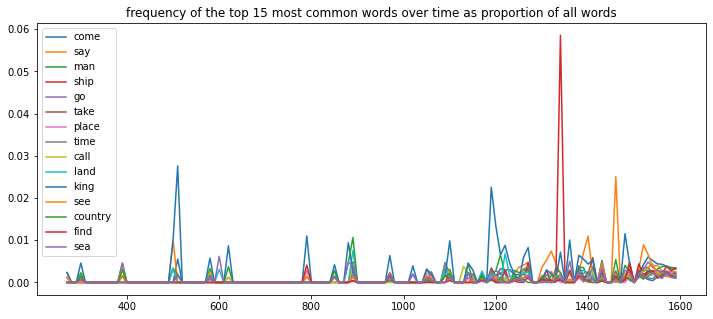

In [29]:
from collections import Counter
hakluyt_track_top_prop = {}
step = 10

for i in range(270,1600,step):
    hakluyt_track_top_prop[i] = Counter()
for fileid in hakluyt_lem.fileids():
    for word in hakluyt_lem.words(fileid):
        if word in tops:
            hakluyt_track_top_prop[HK_date(fileid)//step*step][word]+=1
        hakluyt_track_top_prop[HK_date(fileid)//step*step]['total']+=1
x = hakluyt_track_top_prop.keys()
tops_min = set(tops) - set(['king', 'call', 'ship', 'say'])
for word in tops:
    y = [years[word] / (years['total']+0.00000000001) for years in hakluyt_track_top_prop.values()] #+0.00001 to avoid div-zero error
    plt.plot(x,y, label = word)
plt.legend()
plt.title('frequency of the top 15 most common words over time as proportion of all words')

##### graph

In [30]:
plt.show()

Looking at the relative frequency of top terms, we see a significant fluctuation in just a few (likely driven by outlier documents), while the rest vary within a narrow range that shows no discernible pattern of change over time.

#### top frequent words in Hakluyt vs contemporary histories

In [31]:
# top frequent words in HK vs comparison corpus
# setting up comparison text corpus
comparison_path = 'text-data/comparison_texts/lemd'
comparison = PlaintextCorpusReader(comparison_path, '.*')
comparison_filtered = [t.lower() for t in comparison.words() if t not in stop_words and t.isalpha()]
comparison_fd = nltk.FreqDist(comparison_filtered)

wordfreqs_comp = pd.DataFrame()
wordfreqs_comp['comp'] = comparison_fd.most_common(250)
wordfreqs_comp['Hakluyt'] = compare_freqs(comparison_fd.most_common(250), hakluyt_lem_fd.most_common(250))

In [32]:
print(len(comparison.words()), 'words in the comparison corpus initially;', len(comparison_filtered), 'words filtered for stopwords, numbers and punctuation')
print(len(hakluyt.words()), 'words in Hakluyt initially;', len(hakluyt_lem_filtered), 'words filtered for stopwords, numbers and punctuation')
wordfreqs_comp.T.style.apply(redbold_viol).apply(highlight_shifts)

1761831 words in the comparison corpus initially; 806208 words filtered for stopwords, numbers and punctuation
2077367 words in Hakluyt initially; 970278 words filtered for stopwords, numbers and punctuation


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
comp,"('he', 29710)","('his', 22525)","('king', 18301)","('they', 15346)","('have', 13556)","('it', 7593)","('their', 7456)","('man', 6277)","('great', 6228)","('say', 6028)","('lord', 6023)","('make', 5328)","('come', 5175)","('shall', 5093)","('there', 4924)","('will', 4816)","('take', 4661)","('earl', 4578)","('duke', 4530)","('sir', 4426)","('time', 4379)","('year', 4002)","('i', 3891)","('day', 3506)","('england', 3443)","('you', 3434)","('she', 3433)","('may', 2840)","('send', 2818)","('john', 2701)","('french', 2674)","('town', 2659)","('her', 2627)","('call', 2586)","('queen', 2466)","('son', 2387)","('page', 2299)","('give', 2292)","('henry', 2215)","('first', 2213)","('we', 2200)","('good', 2185)","('realm', 2056)","('cause', 2044)","('can', 2010)","('land', 1990)","('go', 1974)","('france', 1948)","('part', 1871)","('prince', 1869)","('place', 1840)","('edward', 1839)","('himself', 1790)","('bishop', 1739)","('london', 1733)","('set', 1720)","('thing', 1674)","('english', 1670)","('bring', 1660)","('our', 1645)","('see', 1614)","('keep', 1586)","('people', 1556)","('my', 1547)","('name', 1542)","('city', 1540)","('long', 1504)","('without', 1497)","('diverse', 1493)","('castle', 1442)","('war', 1432)","('mean', 1424)","('thomas', 1414)","('country', 1399)","('saint', 1382)","('god', 1361)","('think', 1347)","('return', 1347)","('your', 1339)","('scot', 1331)","('four', 1327)","('know', 1303)","('army', 1285)","('pass', 1272)","('hear', 1270)","('put', 1236)","('reign', 1231)","('person', 1231)","('lie', 1230)","('knight', 1227)","('death', 1212)","('leave', 1200)","('begin', 1188)","('counsel', 1183)","('richard', 1166)","('slay', 1155)","('follow', 1154)","('william', 1136)","('brother', 1120)","('house', 1118)","('hand', 1112)","('die', 1110)","('certain', 1086)","('noble', 1083)","('battle', 1080)","('find', 1077)","('answer', 1061)","('end', 1055)","('write', 1049)","('march', 1036)","('bear', 1022)","('number', 1010)","('father', 1010)","('within', 1008)","('enemy', 973)","('lady', 970)","('show', 967)","('receive', 966)","('daughter', 966)","('church', 963)","('new', 960)","('depart', 959)","('present', 947)","('high', 935)","('crown', 932)","('life', 923)","('parliament', 913)","('ship', 909)","('way', 906)","('enter', 896)","('wife', 896)","('themselves', 896)","('sea', 894)","('peace', 891)","('word', 872)","('matter', 870)","('hold', 860)","('short', 848)","('manner', 846)","('robert', 835)","('law', 828)","('order', 816)","('arm', 808)","('scotland', 804)","('marry', 804)","('right', 801)","('york', 798)","('love', 796)","('archbishop', 786)","('common', 784)","('company', 782)","('captain', 775)","('six', 768)","('honour', 764)","('power', 757)","('master', 754)","('emperor', 752)","('side', 750)","('fall', 750)","('fight', 744)","('friend', 737)","('deliver', 727)","('stand', 725)","('together', 722)","('use', 721)","('desire', 717)","('promise', 716)","('nothing', 715)","('open', 712)","('twenty', 707)","('kingdom', 703)","('chief', 699)","('appoint', 699)","('money', 698)","('towards', 694)","('cardinal', 690)","('live', 687)",

Comparing this 'discourse' to a similar word-volume corpus of several English histories (1568-1643), the following jumps out:
- an apparently prominent us-them polarization--probably not so much a distinctively imperial language indication as a stylistic expression of eyewitness narrative accounts (and the different top pronoun distribution in the English histories again probably reflects a tangle of narrative voice convention and subject matter rather than subject matter alone)
- top term movements are fully in line with content that has to do with travel, including a lot of active verbs, geographic designations, and things to do with ships and sailing.
- interestingly, direct indications of violence only start appearing near the 170th place in Hakluyt--lagging behind the English histories at 70 - with much more cropping up around 200
- something of the hidden nature of colonial violence in Hakluyt can be glimpsed through 'take' at 22nd, often denoting capturing or robbing Native people (though 
- worth noting that cleaning up the text files to start and end at chapter titles rather than page number cuts brought the violent terms up by a few places each--likely indicating that they appear less often in first and last paragraph of any text (which is what mostly got cleaned out)

## American Encounters

Introducing hand-tagged American documents, allowing to single out ones fully or significantly concerned with depictions of or interactions with Native people

##### code

In [33]:
# # another failed attempt at cat_pattern solution -- got it to take a single tag for each file, but crashes at two tags
# #setting up categorized corpus based on hand-tags
# AM_cat_root = 'text-data/CC_ML_FR_trimmed_MAlem_AMER_cat_mod/'
# hakluyt_AM_cat = CategorizedPlaintextCorpusReader(AM_cat_root, '.*', cat_pattern = (r'.*?(expl_y|expl_n|enc_full|enc_part|enc_min|enc_none)'))
# hakluyt_AM_cat.categories()
# #re.findall(r'(expl_y|expl_n|enc_full|enc_part|enc_min|enc_none)', r'07_30.2-1578-En-enc_part-expl_y-Frobishers_first_voyage-278_283')
# #.*?_(?:pos|neg)(?:\.txt)?
# #hakluyt_AM_cat.fileids(categories = 'expl_n')

In [34]:
#select stopword threshold
#stop_words_enc = []
stop_words_enc = stop_words_max
#stop_words_enc = stop_words
AM_cat_root = 'text-data/CC_ML_FR_trimmed_MAlem_AMER_cat_mod/'
#setup expl&enc-tagged categorized corpus - working, if not the most efficient solution via catmap rather than pattern

filelist = os.listdir(AM_cat_root)
fileid_cat = {}
for file in filelist:
    fileid_cat[file] = re.findall(r'(expl_y|expl_n|enc_full|enc_part|enc_min|enc_none)', file)
#from nltk.corpus import CategorizedPlaintextCorpusReader
hakluyt_AM_cat = CategorizedPlaintextCorpusReader(AM_cat_root, '.*', cat_map = fileid_cat)

#print('list of categories: ', hakluyt_AM_cat.categories(), 'number of files: ', len(hakluyt_AM_cat.fileids()))

hakluyt_AM_cat_enc_fd = nltk.ConditionalFreqDist((enc, word)
                                                 for enc in ['enc_full', 'enc_min', 'enc_none', 'enc_part']
                                                 for word in hakluyt_AM_cat.words(categories = enc)
                                                if word.isalpha() and word not in stop_words_enc)

# plaintext corpus for just full/part enc
AM_cat_enc_root = 'text-data/CC_ML_FR_trimmed_MAlem_AMER_cat_mod_enc_full_part/'

hakluyt_AM_enc_part_full = PlaintextCorpusReader(AM_cat_root, r'.*(enc_full|enc_part).*')
hakluyt_AM_enc_part_full_fd = nltk.FreqDist(word for word in hakluyt_AM_enc_part_full.words() if word.isalpha() and word not in stop_words_enc)

hakluyt_AM_enc_full = PlaintextCorpusReader(AM_cat_root, r'.*enc_full.*')
hakluyt_AM_enc_full_fd = nltk.FreqDist(word for word in hakluyt_AM_enc_full.words() if word.isalpha() and word not in stop_words_enc)

#plaintext corpus for AMER total
AMER_root = 'text-data/CC_ML_FR_trimmed_morphad_lem_AMER/'

hakluyt_AMER = PlaintextCorpusReader(AMER_root, '.*')
hakluyt_AMER_fd = nltk.FreqDist(word for word in hakluyt_AMER.words() if word.isalpha() and word not in stop_words_enc)

In [35]:
#comparing most frequent words
#hakluyt_AM_cat_enc_fd.most_common(50)
length=350

wordfreqs_enc = pd.DataFrame()
wordfreqs_enc['AM_tot'] = hakluyt_AMER_fd.most_common(length)
#run a comparison against each enc tag separately
for tag in ['enc_none', 'enc_min', 'enc_part', 'enc_full']:
    wordfreqs_enc[tag] = compare_freqs(wordfreqs_enc['AM_tot'], hakluyt_AM_cat_enc_fd[tag].most_common(length))
#run a comparison just against substantial-encounter chapters
wordfreqs_enc['enc_sig'] = compare_freqs(wordfreqs_enc['AM_tot'],hakluyt_AM_enc_part_full_fd.most_common(length))

##### top word comparisons by encounter flags

In [36]:
wordfreqs_enc.T.style.apply(highlight_shifts).apply(red_viol).apply(bold_viol)
#wordfreqs_enc.T.style.apply(lambda x: ["background: orange" if (token[2] == 'new' or abs(int(token[2])) > 100) else "background: yellow" if abs(int(token[2])) > 15 else "" for token in x], axis = 1).apply(lambda x: ["font-weight: bold" if token[0] in viol_flags else "" for token in x], axis = 1).apply(lambda x: ["color: red" if token[0] in viol_flags else "" for token in x], axis = 1)

Held against the total frequencies of the American section, the encounter-focused sections display interesting patterns of word frequency shifts. Granted, the occasional irregularities in these shifts over the process of refining the table are a strong reminder that, with the lower quantity of text at hand, some of these are bound to be just random effects of text selection--but the aggregate is still significant. I will focus on enc_full, where the effects are most dramatic, but these are largely borne out by enc_sig (aggregating enc_full with enc_part), too.

We see positive jumps in 'people', 'Indians', as well as 'savage'--reflecting the main subject matter of the encounter ('town', interestingly, goes down 52 spots, and city-- down 78--apparently European travelers are much more likely to use these words for European than Native settlements). We see dramatic jumps in 'lord', 'king', and 'Paracoussy', reflecting high-tier negotiations, 'old' may be part of the same trajectory. Woman and child jump ahead, too--there are probably few of either on the ships or in the European settlements addressed in the section. We get more show, tell, understand, answer, speak, and especially sign, indicating communication. There's also an upgrade in war, soldier, enemy, kill, fear, and arrow--not all the interactions are peaceful.  

Sailing and navigational terms cover the vast majority of the significant downshifts (conversely, they go up in the non-encounter sections). They are still, at least in part, relatively prominent, but most of the intercultural encounter indeed takes place on land.

##### extra bits

In [37]:
hakluyt_col = TextCollection(hakluyt)
AMER_col = TextCollection(hakluyt_AMER)
enc_full_col = TextCollection(hakluyt_AM_cat.categories('enc_full'))
enc_sig_col = TextCollection(hakluyt_AM_enc_part_full)

In [38]:
print(type(AMER_col.similar('people')))
print(AMER_col.similar('indian'))
#print(w for w in AMER_col.similar('people') and w in AMER_col.similar('indian'))
print(AMER_col.concordance('ordinance'))

man ship indian country land place island river town boat water other
captain company they time and spaniard day sea
<class 'NoneType'>
ship man people other spaniard country land place river island town
day same boat water sea captain king time savage
None
Displaying 25 of 209 matches:
the court , where we shoot off our ordinance and make the best show we can : he
escribe . a easy kind of fish . of ordinance , and strike all her sail , suppos
t , when hear a piece of our great ordinance , which thunder in the hollowness 
nger by shoot off a piece of great ordinance , new succour of other ship come s
er the sea manner with their great ordinance , and when each party have rip up 
 since report , by shoot off their ordinance , which the other can not hear , n
sary provision , armour , weapon , ordinance , target , and appurti nance whats
r commodious , any law , statute , ordinance or proviso to the contrary thereof
 and ordain , and appoint all such ordinance , order , decree , law , an

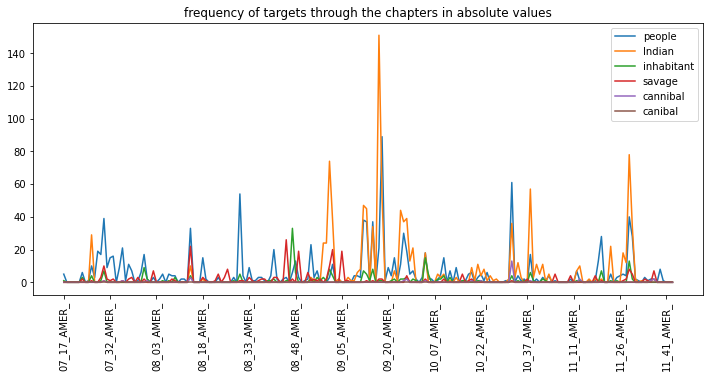

In [39]:
track_words_chapters(hakluyt_AMER, ['people', 'Indian', 'inhabitant', 'savage', 'cannibal', 'canibal'], words_mode = 'separate', count_mode = 'absolute')

## topic modeling

looking through Mallet topic models, at low topic numbers I'm mainly seeing very general topic terms that are vaguely similar to one another, with the exception of very obviously Latin topics and one heavily laden with nautical terms.
As the number of topics increases, topics related to geographical regions start emerging. By 40, there's a distinct one for trade
Thinking on the issue of topics that (look like they probably) straddle documents rather than indicate a coherent 'topic', I recall an earlier realization that my corpus breaks chapters off by page number rather than by the actual chapter titles. A quick count / freq-dist shows that almost half my chapters are 3 pages or shorter, and thus likely impacted by the imprecise breaks. At this point, I should run MALLET diagnostic to confirm the issue of straddle-topics, and if confirmed, go back and figure out a better chapter-breaks solution

Having fixed chapter start/end breaks (losing about 1.2 100k words in the process), not a ton has changed topics-wise. Having looked at the 30-topic spread closely, they seem a little fragmented: 3 topics closely concerned with technical geographical/nautical designations, 3 topics to do with war between different actors, etc. There are distinct regional topics all around. at 20 topics, there is less obviously split topics; interestingly, the distinct war topics have disappeared, while there is still 4 latin topics. On repeat modeling, the war topic re-appeared, and still shows on a 15-topic spread.

A very interesting topic shows in the 15-Am spread, with words such as "come see say certain indians give ... people call find take tell thing ... land woman good far indian sign rest plain carry", its highest values showing in largely Spanish and French ethnographic writings--nearly all, unsurprisiingly, overlapping with full/part enc in the hand-tagged chapters

In [40]:
print(geogs)

['NNE-', 'SSE1', 'SSE2', 'AMER']


##### Penguins pop up surprisingly prominently in the American section, though there's little intrinsic interest in that #####

71  penguins counted through freqdist
48  penguins counted directly from corpus


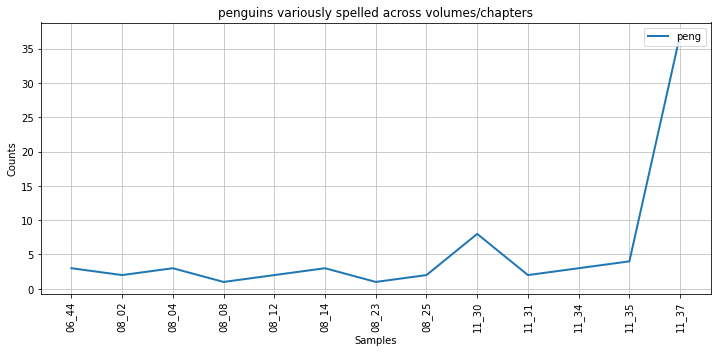

<AxesSubplot:title={'center':'penguins variously spelled across volumes/chapters'}, xlabel='Samples', ylabel='Counts'>

In [41]:
peng_list = ['penguines', 'penguins', 'penguinstand', 'penguin', 'pengwin', 'pengwins', 'pengwyns', 'pengwins', 'penguins', 'penguinisle']
peng_count = 0
for peng in peng_list: peng_count += hakluyt_fd[peng]
print(peng_count, ' penguins counted through freqdist')


peng_count = 0
for fileid in hakluyt.fileids():
    for w in hakluyt.words(fileid):
        if 'peng' in clean_token(w):
            peng_count += 1
            
print(peng_count, ' penguins counted directly from corpus')


hk_penguin_track = nltk.ConditionalFreqDist(('peng', fileid[:5])
                                       for fileid in hakluyt.fileids()
                                       for w in hakluyt.words(fileid)
                                       for target in peng_list
                                       if w.lower() == target)
plt.title('penguins variously spelled across volumes/chapters')
hk_penguin_track.plot()

As expected, penguins are sharply concentrated in just one chapter, which likely accounts for their appearance on the topic model

##### more things to do: #####


- actually read a few of the enthnographic accounts
- map out EG throughout AMER and compare by nationality??
-- could throw the texts back at MALLET and see what comes out
-- just EG passages or whole chapters? could do both of course

try applying 15_am model to the other regions and see what falls under intercult enc?
try applying one of the models to HK's disc of W planting?

look through documents low on the most common expl topic

note:
Native people designations:
Indians
inhabitants
country people
cannibals (that is, hostile Natives)

## violence tracking ##


##### code

In [42]:
from nltk import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from itertools import repeat

In [43]:
def extract_neighbors(text, targets, n, stop_words, include_targets):
    '''
    text : input text as a list of word tokens
    targets : list of keywords of interest
    n : number of words to either side around the keyword
    stop_words : tokens to be skipped; if a token is skipped, the window is extended to make up to the number required
    include_targets : boolean flag determining whether the return will include the keyword of interest or not
    returns a list of lists, each a window of 2n / 2n+1 words centered on keyword
    '''
    #adjustment variables to account for not/including target
    include_target_index_adjust = 0 if include_targets else 1
    include_target_length_adjust = 1 if include_targets else 0
    #initialize return array
    neighbors = []
    #iterate through all the words
    for index, word in enumerate(text):
        if word in targets:
            neighbors_right = []
            neighbors_left = []
            #right side
            right_index = index + include_target_index_adjust
            right_target = index + n 
            while right_index <= right_target:
                if text[right_index] not in stop_words:
                    neighbors_right.append(text[right_index])
                else:
                    right_target += 1
                if right_target < len(text):    
                    right_index += 1
                else:
                    #add empty members
                    while len(neighbors_right) < n + include_target_length_adjust:
                        neighbors_right.append('')
                    #exit text-add loop
                    right_index = right_target + 1
            #left side
            left_index = index - 1
            left_target = index - n
            while left_index >= left_target:
                if text[left_index] not in stop_words:
                    if left_index >= 0:
                        neighbors_left.append(text[left_index])
                    else:
                        neighbors_left.append('')
                else:
                    left_target -= 1
                if left_target > -1:
                    left_index -= 1
                else:
                    #add empty members
                    while len(neighbors_left) < n:
                        neighbors_left.append('')
                    #exit text-add loop
                    left_index = left_target - 1
            neighbors_left.reverse()
            neighbors.append(neighbors_left + neighbors_right)
    return(neighbors)

In [44]:
# for file in hakluyt_lem.fileids():
#     print(extract_neighbors(hakluyt_lem.words(file), viol_flags, 5, stop_words_max, False))
#     break
# for file in hakluyt_lem.fileids():
#     print(extract_neighbors(hakluyt_lem.words(file), viol_flags, 5, stop_words_max, True))
#     break
# test = list(range(-10,11))
# print(extract_neighbors(test, [-9, 5, 10], 3, [], True))

In [45]:
def rank_window(window):
    '''
    takes a list of words presumed to reflect the n neighbors on both sides of a target word
    returns a list of word weighed towards the center--multiplying the words closest to the target
    '''
    #for a window with even number of members, the two center-tied numbers get the highest n/2 multiplier
    ranked_window = []
    if len(window)%2 == 0:
        index = 0
        multiplier = 1
        while index < len(window):
            ranked_window.extend(repeat(window[index], multiplier))
            #ranked_window += window[index] * multiplier
            if index < len(window)/2 - 1:
                multiplier += 1
            elif index > len(window)/2 -1:
                multiplier -= 1
            # in the omitted case of index = n, multiplier doesn't need to change anyway
            index += 1
    #for a window with an uneven number of members, the center number gets the highest (n+1)/2 multiplier
    else:
        index = 0
        multiplier = 1
        while index < len(window):
            ranked_window.extend(repeat(window[index], multiplier))
            if index < (len(window)+1)/2 - 1:
                multiplier += 1
            else:
                multiplier -= 1
            index += 1
    return(ranked_window)

In [46]:
#rank_window(['1', '2', '3', '4', '5', '6', '7'])

In [47]:
def neighbors_fdist(corpus, targets, n, stop_words, include_targets, ranked):
    '''
    corpus: nltk corpus
    targets : list of keywords of interest
    n : number of words to either side around the keyword
    include_targets : boolean flag determining whether the return will include the keyword of interest or not
    ranked: boolean flag weighing the words closest to the keyword higher than those further away
    returns: nltk fdist of the words surrounding the keywords in targets
    '''
    # init word list
    neighbor_words = []
    for file in corpus.fileids():
        neighbors = extract_neighbors(corpus.words(file), targets, n, stop_words, include_targets)
        for window in neighbors:
            if ranked:
                neighbor_words += rank_window(window)
            else:
                neighbor_words += window
            #print(neighbor_words)
    fdist = FreqDist(neighbor_words)
    #print(fdist.most_common(100))
    return(fdist)

In [48]:
def neighbors_wordcloud(corpus, targets, n, stop_words, cloud_words, include_targets, ranked):
    '''
    corpus: nltk corpus
    targets : list of keywords of interest
    n : number of words to either side around the keyword
    stop_words : list of words to leave out of the image
    cloud_words : number of words to be represented in the image
    include_targets : boolean flag determining whether the return will include the keyword of interest or not
    ||| not yet implemented||| ranked: boolean flag weighing the words closest to the keyword higher than those further away
    prints a wordcloud representing the n words around targets in the corpus
    '''    
    fdist = neighbors_fdist(corpus, targets, n, stop_words, include_targets, ranked)
    wcloud_prep = dict([(term, count) for term, count in fdist.items() if len(term)> 2])  #(stop_words_max)]) #(stop_words_max | set(viol_flags))])
    wcloud = WordCloud(width=800, height=400, relative_scaling = 1, min_word_length=2, max_words = cloud_words).generate_from_frequencies(wcloud_prep)  
    #plt.figure(figsize=(20,10))
    plt.imshow(wcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [49]:
# #comparison tables for different parameters

# #range slide
# length=100
# neighbors_track = pd.DataFrame()
# neighbors_track['range_1'] = neighbors_fdist(hakluyt_lem, viol_flags, 1, stop_words_max + viol_flags, include_targets = False, ranked = False).most_common(length)
# for i in range(2,6):
#     neighbors_track['range_'+str(i)] = compare_freqs(neighbors_track['range_1'], neighbors_fdist(hakluyt_lem, viol_flags, i, stop_words_max + viol_flags, include_targets = False, ranked = False).most_common(length))
# neighbors_track.T.style.apply(highlight_shifts)

# #ranking effect
# fdist_unranked = neighbors_fdist(hakluyt_lem, viol_flags, 3, stop_words_max + ['man', 'come'] + punctuation, include_targets = False, ranked = False)
# fdist_ranked = neighbors_fdist(hakluyt_lem, viol_flags, 3, stop_words_max + ['man', 'come'] + punctuation, include_targets = False, ranked = True)
# ranked_comp = pd.DataFrame()
# ranked_comp['unranked'] = fdist_unranked.most_common(100)
# ranked_comp['ranked'] = compare_freqs(fdist_unranked.most_common(100), fdist_ranked.most_common(100))
# ranked_comp.T.style.apply(highlight_shifts)

##### wordclouds

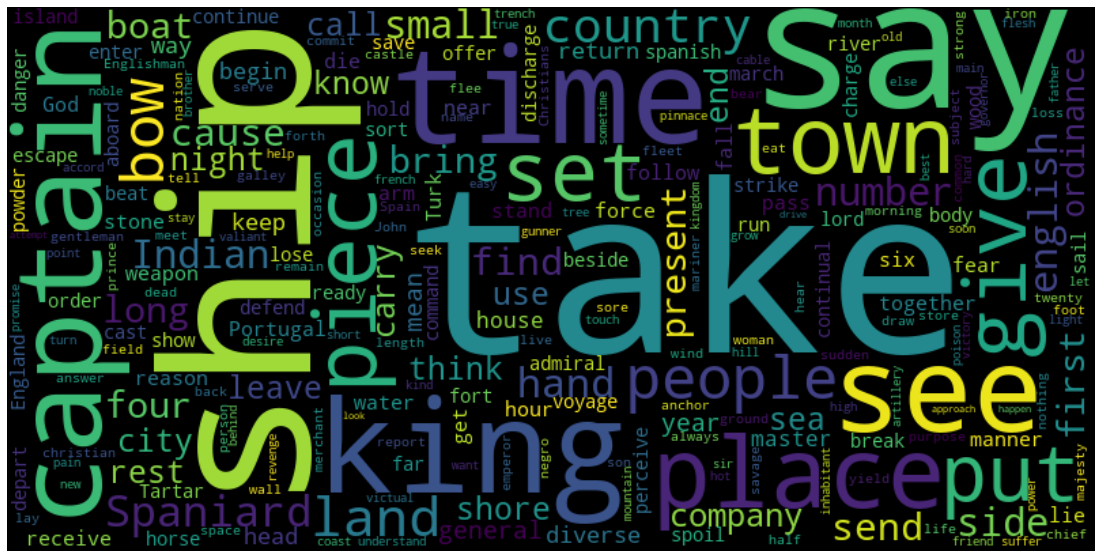

[('they', 4666), ('we', 2072), ('take', 618), ('ship', 562), ('say', 528), ('king', 401), ('time', 385), ('go', 379), ('captain', 357), ('place', 340), ('town', 326), ('see', 324), ('piece', 294), ('bow', 287), ('set', 279), ('give', 276), ('people', 263), ('put', 254), ('country', 248), ('Spaniard', 245), ('land', 236), ('english', 230), ('hand', 222), ('number', 217), ('Indian', 210), ('small', 210), ('side', 205), ('cause', 202), ('send', 196), ('present', 195), ('four', 194), ('find', 191), ('long', 189), ('company', 189), ('first', 189), ('bring', 186), ('sea', 184), ('city', 174), ('rest', 173), ('use', 170), ('ordinance', 170), ('boat', 168), ('night', 165), ('year', 163), ('call', 162), ('general', 162), ('think', 161), ('end', 161), ('mean', 158), ('leave', 157), ('know', 155), ('keep', 153), ('head', 153), ('way', 152), ('diverse', 151), ('return', 150), ('begin', 149), ('carry', 148), ('shore', 142), ('master', 141), ('house', 139), ('force', 130), ('together', 129), ('die',

In [50]:
plt.figure(figsize=(20,10))
sw = stop_words_max + ['man', 'come'] + viol_flags + punctuation
sw.remove('we')
sw.remove('they')
neighbors_wordcloud(hakluyt_lem, viol_flags, 3, sw + ['we', 'they'], cloud_words = 250, include_targets = False, ranked = False)
print(neighbors_fdist(hakluyt_lem, viol_flags, 3, sw, include_targets = False, ranked = False).most_common(250))

Gathering a sampling of meaning-bearing words occuring close to an extended list of violence-related words shows:
- other violence-words: even when excluding the flagged word itself, other violence-bearers show very prominently, reflecting the fact that violence comes as a broad thematic current rather than isolated word occurences
- ships clearly are very often involved, and then kings, captain is another clearly relevant signal; things like time & say are probably just spillovers from their overall frequency
- Indians make a notable appearance, though only about half the weight of combined Spaniard-Spanish-Spain or English-England-Englishman (~60% for ranges 1-2; ~50% for 3-5)
- extending the window too far results in a sampling that looks much like the top frequent words

- 'take' suggestively appears at the top of violence-neighbors list (after dispensing with higher-frequency words that are hard to tie to any specific meaning, such as 'great' or 'man'); I will refer to it as a second-tier instance: not obviously related to a query, but promising further insight on closer investigation
    - A concordance search does flag a few throwaways - 'take heed' or 'take for', but many are of clear relevance - 'take or kill yong birds', or 'take up souldiers out of every countrey of their dominions'. Many instances of 'take' do in fact constitute violence that escapes the keyword search - 'take the wealth of the countrey', 'take possession of this Island', and possibly 'take unto wife'
    - a wordclouds of 'take' neighbors brings out a lot of noise, but we also see direct violence indicators (slay, burn, kill) as well as intriguing potentials - taking a ship may relate to battle, taking land, islands, or taking possession sounds a lot like conquest, taking prisoner is clearly coercive, and taking 'negro' is clearly involved in slavery. Taking wives or women; taking victual, taking Indians or Spanish... Granted, some of the listed instances may involve the subject (i.e., Indian or woman) taking something else, but quickly commenting out the left-side gathering of neighboring words still leaves a considerable contingent of Indains, Negros and wives on the right side of 'take'.

In [51]:
#hakluyt_col.concordance('take', 200)
#neighbors_wordcloud(hakluyt_lem, ['take'], 3, stop_words_max, cloud_words = 250, include_targets = False, ranked = False)

violent neighbors across Hakluyt's entire compilation


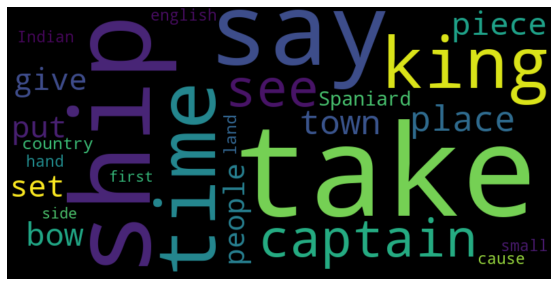

violent neighbors in just the American section


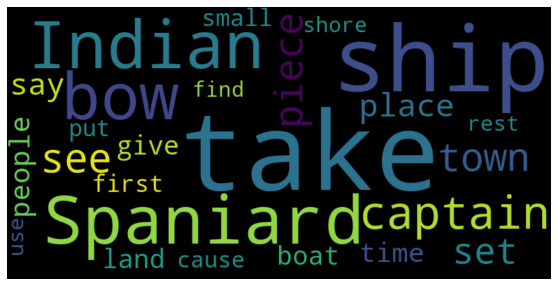

In [52]:
plt.figure(figsize=(10,5))
print('violent neighbors across Hakluyt\'s entire compilation')
neighbors_wordcloud(hakluyt_lem, viol_flags, 3, stop_words_max + ['man', 'come'] + viol_flags, cloud_words = 25, include_targets = False, ranked = False)
print('violent neighbors in just the American section')
plt.figure(figsize=(10,5))
neighbors_wordcloud(hakluyt_AMER, viol_flags, 3, stop_words_max + ['man', 'come'] + viol_flags, cloud_words = 25, include_targets = False, ranked = False)

In [53]:
wordfreqs_comp = pd.DataFrame()
wordfreqs_comp['total'] = neighbors_fdist(hakluyt_lem, viol_flags, 3, stop_words_max + ['man', 'come'] + viol_flags + punctuation, include_targets = False, ranked = False).most_common(250)
wordfreqs_comp['AMER'] = compare_freqs(neighbors_fdist(hakluyt_lem, viol_flags, 3, stop_words_max + ['man', 'come'] + viol_flags + punctuation, include_targets = False, ranked = False).most_common(250),
                                       neighbors_fdist(hakluyt_AMER, viol_flags, 3, stop_words_max + ['man', 'come'] + viol_flags + punctuation, include_targets = False, ranked = False).most_common(250))
wordfreqs_comp.T.style.apply(redbold_viol).apply(highlight_shifts)
# track_words_chapters(hakluyt_lem, ['Spaniard', 'Spain', 'spanish'], words_mode = 'grouped', count_mode = 'absolute')
# track_words_chapters(hakluyt_lem, ['Indian'], words_mode = 'grouped', count_mode = 'absolute')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
total,"('take', 715)","('ship', 630)","('say', 588)","('go', 451)","('time', 428)","('king', 417)","('captain', 387)","('see', 384)","('place', 380)","('town', 362)","('piece', 333)","('give', 331)","('set', 316)","('put', 298)","('people', 297)","('bow', 297)","('land', 271)","('country', 271)","('Spaniard', 267)","('hand', 251)","('number', 239)","('english', 238)","('small', 236)","('Indian', 233)","('side', 231)","('cause', 225)","('find', 225)","('send', 223)","('present', 218)","('four', 217)","('bring', 216)","('long', 214)","('first', 211)","('boat', 211)","('company', 208)","('sea', 199)","('city', 197)","('ordinance', 193)","('use', 190)","('shore', 189)","('leave', 185)","('rest', 184)","('night', 183)","('think', 182)","('carry', 179)","('know', 179)","('call', 178)","('end', 178)","('general', 178)","('mean', 176)","('year', 175)","('return', 170)","('head', 170)","('begin', 168)","('keep', 164)","('diverse', 163)","('way', 162)","('house', 152)","('master', 150)","('together', 144)","('force', 144)","('fall', 143)","('near', 141)","('die', 139)","('Portugal', 138)","('arm', 135)","('God', 135)","('lie', 134)","('pass', 133)","('water', 133)","('six', 129)","('weapon', 129)","('Turk', 129)","('hour', 126)","('receive', 125)","('stand', 124)","('manner', 124)","('stone', 121)","('reason', 120)","('follow', 119)","('get', 119)","('fear', 119)","('body', 114)","('far', 114)","('depart', 114)","('enter', 113)","('show', 113)","('sail', 111)","('horse', 111)","('escape', 111)","('perceive', 111)","('river', 110)","('lord', 110)","('cast', 108)","('continue', 108)","('beside', 107)","('break', 107)","('beat', 106)","('sort', 106)","('strike', 105)","('defend', 105)","('wood', 104)","('island', 103)","('voyage', 103)","('continual', 102)","('march', 101)","('offer', 101)","('command', 100)","('save', 100)","('admiral', 100)","('order', 99)","('spanish', 98)","('danger', 97)","('fort', 97)","('run', 96)","('aboard', 96)","('England', 95)","('discharge', 94)","('powder', 94)","('lose', 91)","('ready', 91)","('spoil', 90)","('Tartar', 90)","('charge', 90)","('hold', 89)","('gentleman', 89)","('fleet', 88)","('wall', 88)","('loss', 88)","('tell', 87)","('negro', 86)","('Englishman', 85)","('name', 85)","('flee', 84)","('chief', 84)","('hear', 83)","('purpose', 83)","('back', 83)","('half', 83)","('galley', 83)","('mariner', 82)","('lay', 82)","('forth', 82)","('anchor', 82)","('morning', 81)","('answer', 81)","('common', 80)","('store', 80)","('twenty', 79)","('wind', 79)","('strong', 78)","('dead', 78)","('christian', 78)","('emperor', 78)","('castle', 77)","('always', 77)","('woman', 76)","('field', 75)","('sore', 75)","('report', 75)","('majesty', 75)","('nothing', 75)","('live', 74)","('son', 74)","('length', 74)","('prince', 73)","('bear', 73)","('draw', 73)","('life', 73)","('merchant', 73)","('remain', 72)","('sudden', 72)","('John', 72)","('eat', 72)","('subject', 72)","('Spain', 72)","('savage', 72)","('space', 71)","('nation', 71)","('iron', 71)","('seek', 71)","('meet', 69)","('3', 68)","('ground', 68)","('occasion', 67)","('Christians', 66

Comparing the semantic neighborhood of violence in the American section vs all across the compilation, the renewed prominence of Spaniard and Indian certainly jumps out - from around #20 to #5; 'savage' jumps from #170 to #60. 

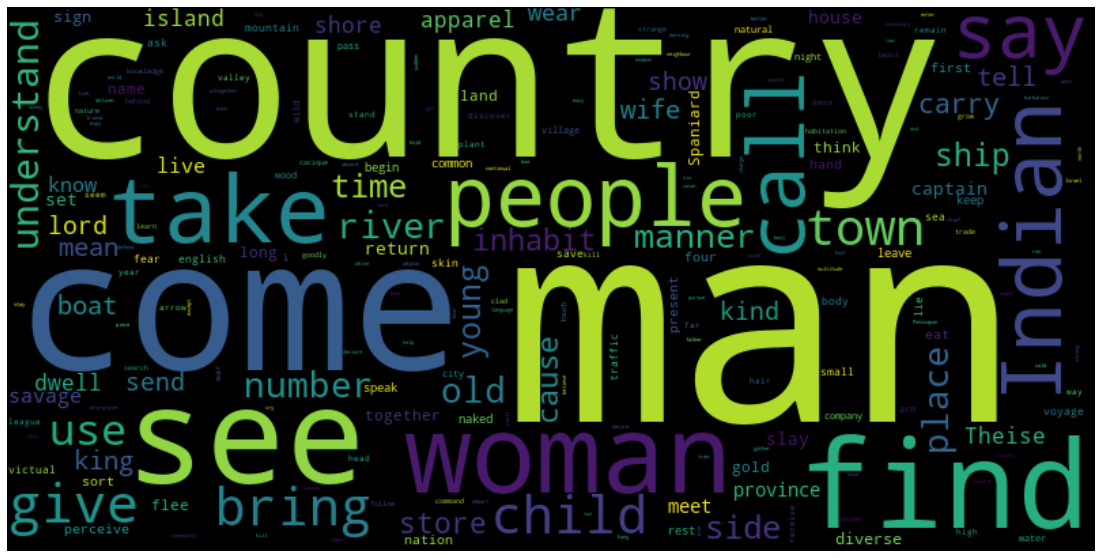

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
Amer,"('man', 320)","('country', 277)","('come', 232)","('go', 162)","('see', 148)","('find', 144)","('take', 132)","('woman', 125)","('people', 123)","('say', 120)","('Indian', 104)","('call', 100)","('place', 95)","('town', 92)","('bring', 87)","('give', 87)","('child', 82)","('Spaniard', 78)","('use', 76)","('river', 72)","('island', 68)","('ship', 68)","('land', 66)","('time', 66)","('inhabit', 62)","('understand', 57)","('manner', 54)","('number', 52)","('shore', 51)","('store', 51)","('tell', 51)","('mean', 50)","('side', 50)","('boat', 50)","('old', 49)","('know', 49)","('savage', 49)","('leave', 48)","('captain', 48)","('cause', 48)","('king', 48)","('kind', 47)","('show', 47)","('wife', 47)","('live', 45)","('house', 45)","('first', 45)","('carry', 44)","('young', 43)","('rest', 42)","('city', 42)","('dwell', 42)","('send', 41)","('apparel', 41)","('lord', 41)","('year', 40)","('long', 40)","('return', 39)","('voyage', 39)","('meet', 38)","('hand', 38)","('slay', 38)","('flee', 37)","('english', 37)","('nation', 36)","('wear', 36)","('diverse', 36)","('present', 35)","('set', 35)","('sort', 35)","('pass', 35)","('sea', 34)","('skin', 34)","('think', 34)","('fear', 34)","('speak', 34)","('Theise', 34)","('naked', 34)","('name', 33)","('water', 33)","('small', 33)","('victual', 33)","('save', 32)","('way', 31)","('far', 31)","('four', 31)","('person', 31)","('sign', 30)","('gold', 30)","('company', 30)","('keep', 30)","('begin', 30)","('wood', 30)","('province', 30)","('common', 29)","('mountain', 29)","('perceive', 29)","('natural', 29)","('war', 28)","('league', 28)","('seem', 27)","('eat', 27)","('together', 27)","('body', 27)","('wild', 26)","('answer', 26)","('bear', 26)","('fair', 24)","('arm', 24)","('discover', 23)","('arrow', 23)","('God', 23)","('ask', 23)","('stand', 23)","('follow', 22)","('traffic', 22)","('night', 22)","('kill', 22)","('trade', 21)","('poor', 21)","('plant', 21)","('fish', 20)","('near', 20)","('strange', 20)","('nature', 20)","('continual', 20)","('better', 20)","('die', 20)","('stay', 19)","('cover', 19)","('enter', 19)","('coast', 19)","('south', 19)","('put', 19)","('receive', 19)","('desire', 19)","('behind', 19)","('lie', 19)","('except', 19)","('remain', 19)","('cold', 18)","('high', 18)","('hair', 18)","('best', 18)","('hold', 18)","('love', 18)","('Portugal', 17)","('depart', 17)","('language', 17)","('knowledge', 17)","('necessary', 17)","('aboard', 17)","('grow', 17)","('canoas', 17)","('friend', 16)","('adjoin', 16)","('want', 16)","('Indies', 16)","('white', 16)","('colour', 16)","('enemy', 16)","('end', 16)","('head', 16)","('nothing', 16)","('travel', 16)","('aswell', 16)","('goodly', 16)","('command', 16)","('beast', 15)","('barbarous', 15)","('learn', 15)","('reason', 15)","('deliver', 15)","('valley', 15)","('dance', 15)","('respect', 15)","('work', 15)","('village', 15)","('commodity', 14)","('father', 14)","('touch', 14)","('black', 14)","('hill', 14)","('hear', 14)","('twenty', 14)","('get', 14)","('friendship', 14)","('north', 14)","('piece', 14)","('report', 14)","('beside', 14)","('government

In [54]:
# hakluyt_col.similar('Indian')
# print('\n \n')
# enc_sig_col.similar('Indian')
plt.figure(figsize=(20,10))
nat_flags = ['indian', 'savage', 'cannibal', 'interpreter', 'inhabitant', 'naked', 'people', 'woman', 'child', 'cacique', 'Pemisapan']
neighbors_wordcloud(hakluyt_AM_enc_part_full, nat_flags, 3, stop_words_max, cloud_words = 250, include_targets = False, ranked = False)
nat_comp = pd.DataFrame()
nat_comp['Amer'] = neighbors_fdist(hakluyt_AMER, nat_flags, 3, stop_words_max + punctuation, include_targets = False, ranked = False).most_common(250)
nat_comp['enc_part_full'] = compare_freqs(nat_comp['Amer'],
                                       neighbors_fdist(hakluyt_AM_enc_part_full, nat_flags, 3, stop_words_max + punctuation, include_targets = False, ranked = False).most_common(250))
nat_comp['enc_full'] = compare_freqs(nat_comp['Amer'],
                                       neighbors_fdist(hakluyt_AM_enc_full, nat_flags, 3, stop_words_max + punctuation, include_targets = False, ranked = False).most_common(250))
nat_comp.T.style.apply(redbold_viol).apply(highlight_shifts)

- At relative scaling of 1 -- tying wordcloud text size directly to frequency--a lot of the hits are barely large enough to make out, suggesting that the lexical neighborhood isn't very consistent, thus featuring a lot of low-frequency stragglers

- Trying to get a sense of the bag-of-words representation of Native people is a harder case than violence:
  - (basically filling out the list of flags by scrutinizing the 'neighborhood' of the first intuitive guesses and testing / adding prospective additional hits--though afther the first few guesses, what I've been adding seems low-frequency enough that it doesn't change the picture much)
  - the list of words directly designating them is quite short - Indian and savage cover most general references, and 'inhabitant' is pretty reliable; Cacique, Pemipasan, and cannibal make for a few very specific references, but are pretty rare. 
  - People don't exclusively designate Native people, but do more often than not; interestingly, a little above half of Hakluyt's 'people' appear in ther American section. 
  - 'Naked' is a very reliable and quite meaningful designator; 
  - the women and children showing in these texts are, for clear historical reasons, largely non-European.

- Country shows up as the top hit (after eliminating meaning-light words such as 'great' and 'man'). It's definitely a second-tier signal,
  - Can I stretch it as far as 'Native people are closely tied to the land'?
  - add 'possess*', land, and animals / natural resources 
  - thus, 34,000 'dry' penguins (not to mention the majority of penguin-hunting that does not recount numbers) suggests no less than ecological devastation



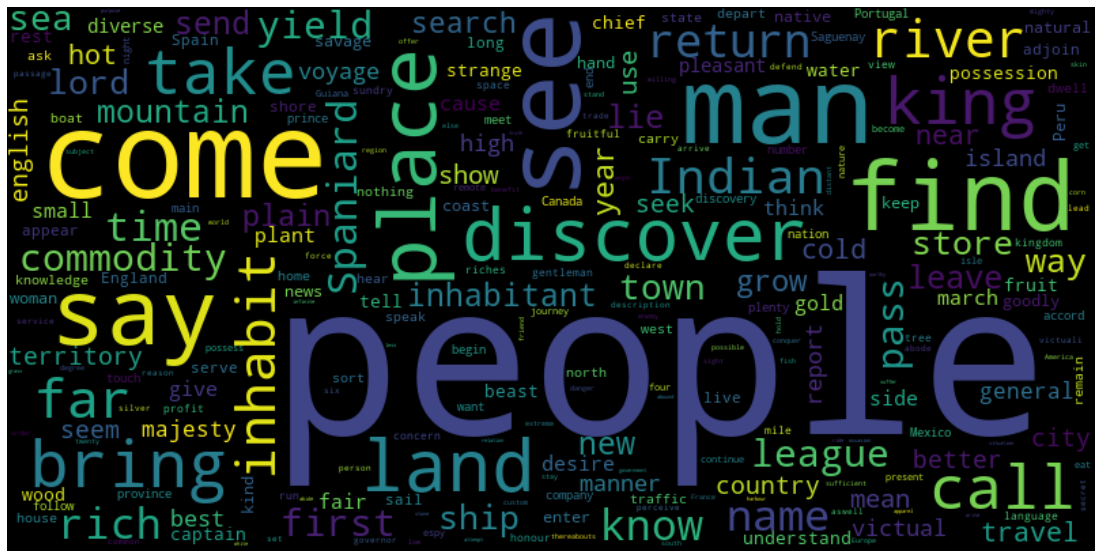

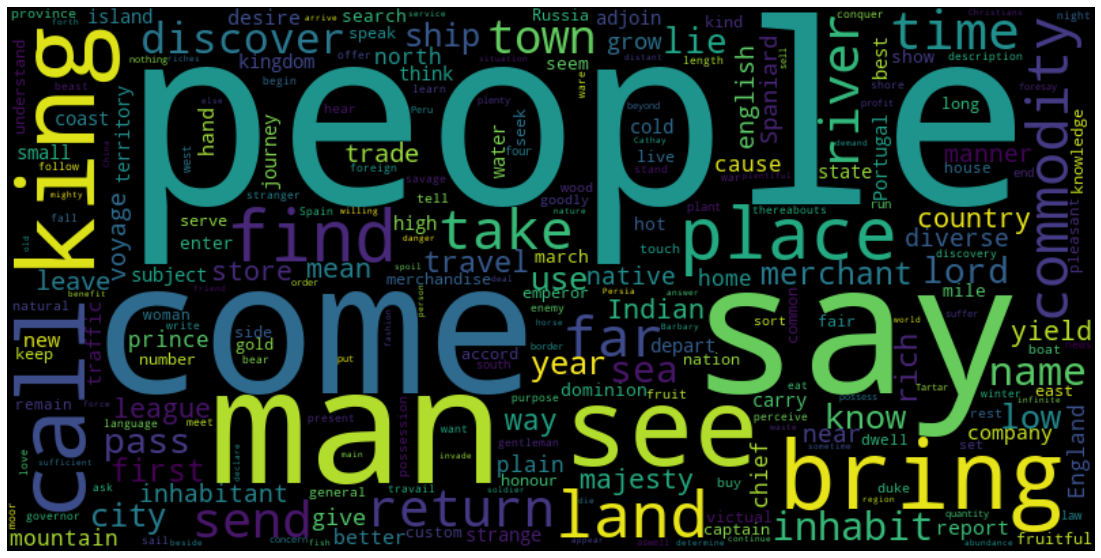

Displaying 22 of 1677 matches:
wn , where he see many strange thing . Humf . Lloyd . this land must needs be some part of that country of which the Spaniard affirm themselves to be the first finder since hannos time . whereupon it
affirm themselves to be the first finder since hannos time . whereupon it be manifest that that country be by Britain discover , long before Columbus lead any Spaniard thither . of the voyage and ret
 sure it be there he be . and after he have return home , and declare the pleasant and fruitful country hat he have see without inhabitant , and upon the contrary part , for what barren and wild the 
ain . therefore it be to be suppose that he and his people inhabit part of those Gomara . lib . country : for it appear by Francis Lopez de Gomara , » • cap . 16 . that in Acuzamil and other place th
 come unto , and use the language they find there . m . Powels this Madoc arrive in the western country , unto addition . the whjch he camejn the year 1170 , leave most 

In [55]:
plt.figure(figsize=(20,10))
neighbors_wordcloud(hakluyt_AMER, ['country'], 3, stop_words_max, cloud_words = 250, include_targets = False, ranked = False)
plt.figure(figsize=(20,10))
neighbors_wordcloud(hakluyt_lem, ['country'], 3, stop_words_max, cloud_words = 250, include_targets = False, ranked = False)
AMER_col.concordance('country', 200, 22)

